In [1]:
import os
os.listdir(r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files")

['sample_submission.csv',
 'test.csv',
 'test_images',
 'train.csv',
 'train_images']

In [2]:
import time
# for printing progressive bars
from tqdm import tqdm
#for excessing or creating tabular data
import pandas as pd
import pandas.util.testing as tm
# for matrix multiplication
import numpy as np
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
# for splitting the data
from sklearn.model_selection import train_test_split

<ipython-input-2-ae40097c2182>:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train_data = pd.read_csv(r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\train.csv")
print("train.csv:")
print("Number of Training images: {}\n".format(train_data.shape[0]))
print(train_data.head(2),"\n")
print("-"*100)
test_data = pd.read_csv(r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\test.csv")
print("test.csv: ")
print("Number of Testing images: {}\n".format(test_data.shape[0]))
print(test_data.head(2))
print("\n","-"*100)
print("sample_submission.csv:")
sample_submission = pd.read_csv(r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\sample_submission.csv")
print("The format of submitting the final predictions on testing images: ")
print(sample_submission.head(5))

train.csv:
Number of Training images: 3662

        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4 

----------------------------------------------------------------------------------------------------
test.csv: 
Number of Testing images: 1928

        id_code
0  0005cfc8afb6
1  003f0afdcd15

 ----------------------------------------------------------------------------------------------------
sample_submission.csv:
The format of submitting the final predictions on testing images: 
        id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0


In [4]:
# Initialisation of variables which are useful for the latter tasks.

img_width = 512
img_height = 512
no_channels = 3
split_size = 0.15
class_labels = {0: 'No DR[0]',1: 'Mild[1]', 2: 'Moderate[2]', 3: 'Severe[3]', 4: 'Proliferative DR[4]'}

# Exploratory Data Analysis:

Number of Images in train dataset:  3662
Number of Images in test dataset:  1928


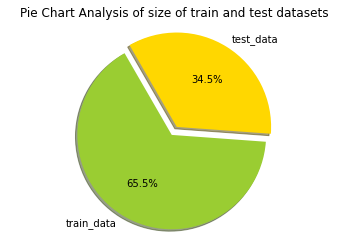

In [5]:
data = [len(train_data), len(test_data)]
print("Number of Images in train dataset: ", data[0])
print("Number of Images in test dataset: ", data[1])
labels = ['train_data','test_data']
plt.pie(data,explode = [0,0.1], labels= labels, shadow = True, colors = ['yellowgreen','gold'],autopct='%1.1f%%', startangle = 120)
plt.title('Pie Chart Analysis of size of train and test datasets')
plt.axis('equal')
plt.show()

In [6]:
# Both the training and test folders are not too large, 
# Which may not be sufficient for model training. 
# Since the model training is with fewer images, 
# it gets overfitted too easily. So we need to come up with 
# different data augmentation techniques and make use of 
# pretrained models (Transfer Learning) in order to improve the model training.

# The train data set is three times larger than the test data set.

In [7]:
class_labels_ = list(set(train_data['diagnosis'])) 
print("Number of target classes: {}".format(class_labels_))

Number of target classes: [0, 1, 2, 3, 4]


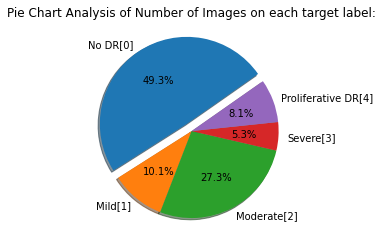

In [8]:
class_sizes = []
for i in range(0,5):
    class_sizes.append(list(train_data['diagnosis']).count(i))
labels = class_labels.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','darkgreen']
plt.pie(class_sizes,explode = [0.1,0,0,0,0], labels= labels, shadow = True,autopct='%1.1f%%', startangle = 35)
plt.title('Pie Chart Analysis of Number of Images on each target label:')
plt.show()

In [9]:
# We can see that the data is heavily imbalanced. Their are ten times more images with No DR condition than the images with Severe condion.
# Adding class_weights may solve our problem.

In [10]:
def image_analysis(dataframe, path):
    width_range = []
    height_range = []
    for i in range(dataframe.shape[0]):
        img = cv2.imread(path+dataframe.iloc[i]['id_code']+'.png')
        height, width, _ = img.shape
        width_range.append(width)
        height_range.append(height)
    return width_range, height_range
width_range, height_range = image_analysis(train_data, r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\train_images/')

In [11]:
avg_width = sum(width_range)/len(width_range)
avg_height = sum(height_range)/len(height_range)
max_width = max(width_range)
max_height = max(height_range)
min_width = min(width_range)
min_height = min(height_range)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print("-"*100)
print("Maximum width of images in training set: {}".format(max_width))
print("Maximum height of images in training set: {}".format(max_height))
print("-"*100)
print("Minimum width of images in training set: {}".format(min_width))
print("Minimum height of images in training set: {}".format(min_height))

Average width of images in training set: 2015
Average height of images in training set: 1526
----------------------------------------------------------------------------------------------------
Maximum width of images in training set: 4288
Maximum height of images in training set: 2848
----------------------------------------------------------------------------------------------------
Minimum width of images in training set: 474
Minimum height of images in training set: 358


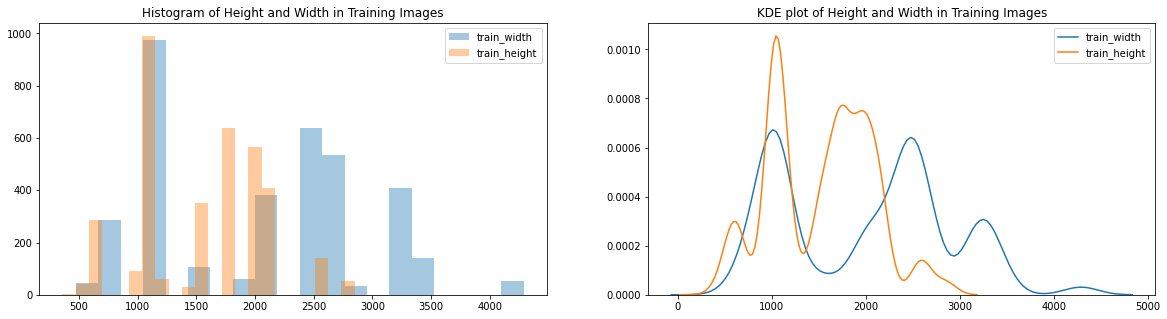

In [12]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range, kde = False, label = 'train_width')
sns.distplot(height_range, kde = False, label = 'train_height')
plt.legend()
plt.title("Histogram of Height and Width in Training Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range, label = 'train_width')
sns.kdeplot(height_range, label = 'train_height')
plt.legend()
plt.title('KDE plot of Height and Width in Training Images')
plt.show()

In [13]:
width_range_test, height_range_test = image_analysis(test_data, r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\test_images/')
avg_width = sum(width_range_test)/len(width_range_test)
avg_height = sum(height_range_test)/len(height_range_test)
max_width = max(width_range_test)
max_height = max(height_range_test)
min_width = min(width_range_test)
min_height = min(height_range_test)
print("Average width of images in training set: {}".format(int(avg_width)))
print("Average height of images in training set: {}".format(int(avg_height)))
print('-'*100)
print("Maximum width of images in test set: {}".format(max_width))
print("Maximum height of images in test set: {}".format(max_height))
print('-'*100)
print("Minimum width of images in test set: {}".format(min_width))
print("Minimum height of images in test set: {}".format(min_height))

Average width of images in training set: 1043
Average height of images in training set: 783
----------------------------------------------------------------------------------------------------
Maximum width of images in test set: 2896
Maximum height of images in test set: 1958
----------------------------------------------------------------------------------------------------
Minimum width of images in test set: 640
Minimum height of images in test set: 480


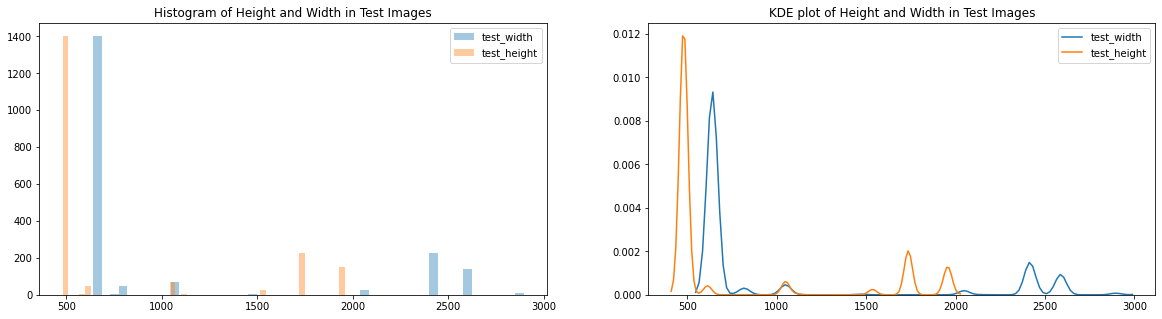

In [14]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.distplot(width_range_test, kde = False, label = 'test_width')
sns.distplot(height_range_test, kde = False, label = 'test_height')
plt.legend()
plt.title("Histogram of Height and Width in Test Images")
plt.subplot(1,2,2)
sns.kdeplot(width_range_test, label = 'test_width')
sns.kdeplot(height_range_test, label = 'test_height')
plt.legend()
plt.title('KDE plot of Height and Width in Test Images')
plt.show()

## Spilitting Dataset:

In [15]:
def splitting_data(train_data, size, is_split = True):
    """
       This function splits the given data into train and validation sets basing on size for validation.
       Args : df - (dataframe) through which splitting is performed 
            size - (Integer) test_size -> percentage of data for validation set 
            is_split = (boolean) returns train and validation if it is True , otherwise it simply returns the train data
       Outputs : (Series Object) train and validation sets of data 

    """
    try:
        if is_split:
            data = train_data['id_code']
            labels = train_data['diagnosis']
            train_x, validation_x, train_labels, validation_labels = train_test_split(data, labels, stratify=labels, shuffle=True, test_size=size)
            print("Training data: {} {}".format(train_x.shape, train_labels.shape))
            print("Validation data: {} {}".format(validation_x.shape,validation_labels.shape))
            return train_x, train_labels, validation_x, validation_labels
        else:
            return train_data['id_code'], train_data['diagnosis'], [], []
    except:
        print("Error: Invalid file format, Function argument requires .csv file!!!")

In [16]:
train_x, train_labels, validation_x, validation_labels = splitting_data(train_data, split_size)   # function calling

Training data: (3112,) (3112,)
Validation data: (550,) (550,)


#### Target Label Analysis On Train And Validation Sets:

In [17]:
def class_analysis(labels, d_set):
    """
    This function plots the histogram of class labels for given set of labels.
    Args : labels - (Series object) which contains the class_labels of train or validation sets.
           d_set - (String) which helps to known whether it is a train or validation set.
    Output : None - this function doesn't return anything
    """
    if d_set == 'training': print("-"*100,'\n')
    counter = labels.value_counts().sort_index()
    counter.plot(kind = 'bar')
    plt.title('Number of images for each Class label in {} set'.format(d_set))
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.grid()
    plt.show()
    iter=0

    for i in list(set(labels)):
        percentage = list(labels).count(i)/len(list(labels))
        print("Number of images in class - {} ({}) , nearly {} % of total data".format(i,class_labels[i],np.round(percentage*100,4)))
        iter+=1
    if d_set == 'training':
        print("\n","="*100,"\n")
    if d_set == 'validation': print("-"*100,'\n')

---------------------------------------------------------------------------------------------------- 



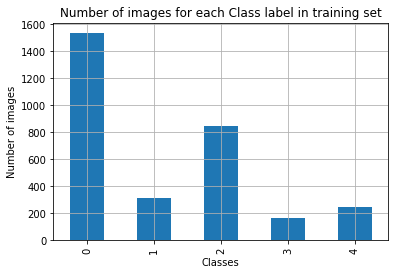

Number of images in class - 0 (No DR[0]) , nearly 49.2931 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.09 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.2815 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.2699 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.0656 % of total data




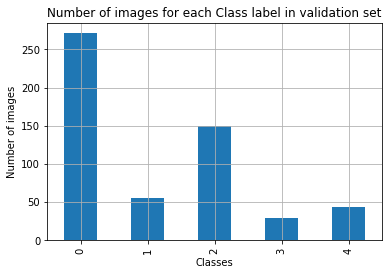

Number of images in class - 0 (No DR[0]) , nearly 49.2727 % of total data
Number of images in class - 1 (Mild[1]) , nearly 10.1818 % of total data
Number of images in class - 2 (Moderate[2]) , nearly 27.2727 % of total data
Number of images in class - 3 (Severe[3]) , nearly 5.2727 % of total data
Number of images in class - 4 (Proliferative DR[4]) , nearly 8.0 % of total data
---------------------------------------------------------------------------------------------------- 



In [18]:
class_analysis(train_labels,'training')
class_analysis(validation_labels,'validation')

## Image Preprocessing:

In [19]:
class ImageProcessing:
    def __init__(self, img_height, img_width, no_channels, tol=7, sigmaX=8):

        ''' Initialzation of variables'''

        self.img_height = img_height
        self.img_width = img_width
        self.no_channels = no_channels
        self.tol = tol
        self.sigmaX = sigmaX

    def cropping_2D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the GRAY images'''

        mask = img>self.tol
        return img[np.ix_(mask.any(1),mask.any(0))]

    def cropping_3D(self, img, is_cropping = False):

        '''This function is used for Cropping the extra dark part of the RGB images'''

        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>self.tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # if image is too dark we return the image
            return img 
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1),mask.any(0))]  #for channel_1 (R)
            img2 = img[:,:,1][np.ix_(mask.any(1),mask.any(0))]  #for channel_2 (G)
            img3 = img[:,:,2][np.ix_(mask.any(1),mask.any(0))]  #for channel_3 (B)         
            img = np.stack([img1,img2,img3],axis=-1)
        return img

    def Gaussian_blur(self, img, is_gaussianblur = False):

        '''This function is used for adding Gaussian blur (image smoothing technique) which helps in reducing noise in the image.'''

        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img,(0,0),self.sigmaX),-4,128)
        return img

    def draw_circle(self,img, is_drawcircle = True):

        '''This function is used for drawing a circle from the center of the image.'''

        x = int(self.img_width/2)
        y = int(self.img_height/2)
        r = np.amin((x,y))     # finding radius to draw a circle from the center of the image
        circle_img = np.zeros((img_height, img_width), np.uint8)
        cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
        img = cv2.bitwise_and(img, img, mask=circle_img)
        return img

    def image_preprocessing(self, img, is_cropping = True, is_gaussianblur = True):

        """
        This function takes an image -> crops the extra dark part, resizes, draw a circle on it, and finally adds a gaussian blur to the images
        Args : image - (numpy.ndarray) an image which we need to process
           cropping - (boolean) whether to perform cropping of extra part(True by Default) or not(False)
           gaussian_blur - (boolean) whether to apply gaussian blur to an image(True by Default) or not(False)
        Output : (numpy.ndarray) preprocessed image
        """

        if img.ndim == 2:
            img = self.cropping_2D(img, is_cropping)  #calling cropping_2D for a GRAY image
        else:
            img = self.cropping_3D(img, is_cropping)  #calling cropping_3D for a RGB image
        img = cv2.resize(img, (self.img_height, self.img_width))  # resizing the image with specified values
        img = self.draw_circle(img)  #calling draw_circle
        img = self.Gaussian_blur(img, is_gaussianblur) #calling Gaussian_blur
        return img

In [20]:
def images_per_class(class_labels,num, data_x , is_preprocess = False):

    """ 
    This function plots "num" number of images per each class
    Args : class_labels - (Series Object) which contains the class_labels of train or validation sets.
           num - (Integer) sample number of images to be plot per each class
           data_x - (Series Object) which contains the id_code of each point in train or validation sets.
           is_preprocess - (boolean) whether to perform image processing(True) on image or not(False by Default) 
    Output : None - this function doesn't return anything.
    """

    # class_labels num data_x data_y
    labels = list(set(class_labels))
    classes = ['No DR','Mild','Moderate','Severe','Proliferative DR']
    iter=0
    for i in labels:
        j=1
        plt.figure(figsize=(20,5))
        for row in range(len(data_x)):
            if class_labels.iloc[row] == i:
                if is_preprocess == False:plt.subplot(1,num,j)
                else: plt.subplot(1,num*2,j)
                img = cv2.imread(r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\train_images/'+data_x.iloc[row]+'.png')
                img1 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                plt.imshow(img1)
                plt.axis('off')
                plt.title("Class = {} ({})".format(class_labels.iloc[row],classes[iter]))
                j+=1
                if is_preprocess == True:
                    obj = ImageProcessing(img_width,img_height,no_channels,sigmaX=14)
                    image = obj.image_preprocessing(img)
                    plt.subplot(1,num*2,j)
                    plt.imshow(image)
                    plt.axis('off')
                    plt.title('==> After Image Processing')
                    j+=1
            if is_preprocess == False and j>num: break
            elif is_preprocess == True and j>num*2: break
        iter+=1
        plt.show()

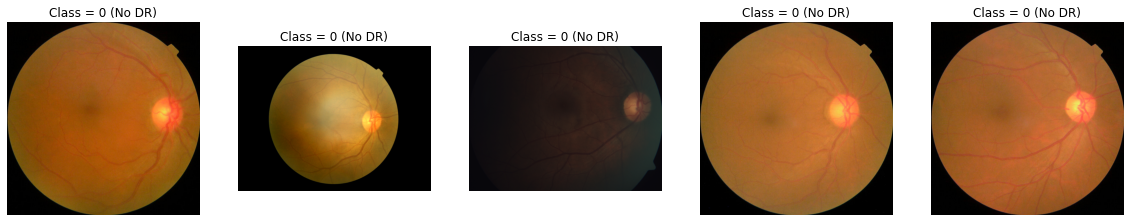

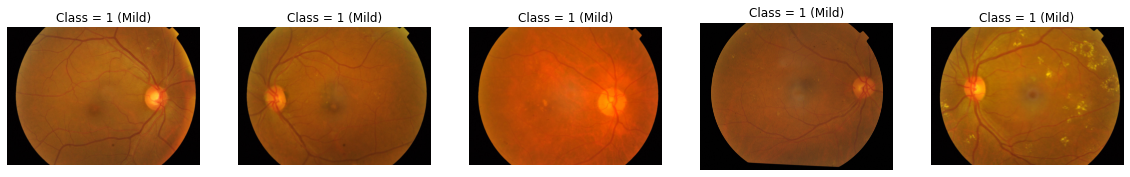

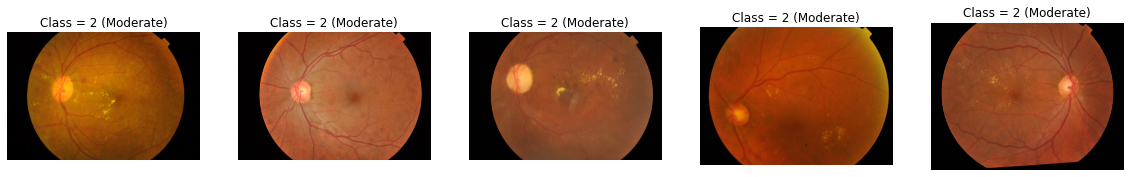

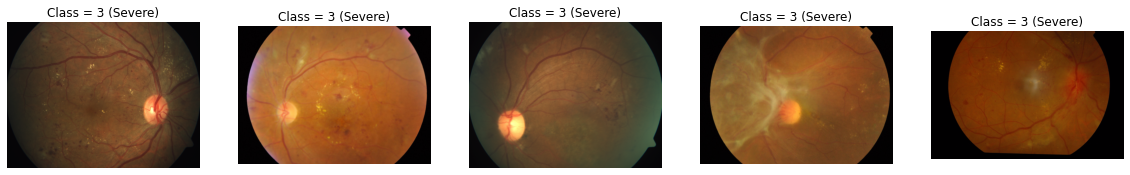

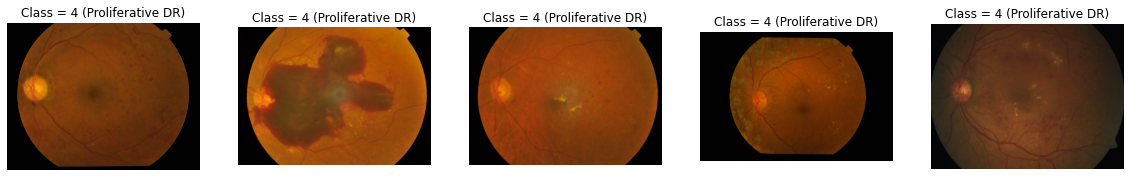

In [21]:
images_per_class(train_labels,5,train_x,False)  #printing 5 random images per each class.

## Exploring the Dataset

In [22]:
def plotting(img, title,i):
    """
    This function is used for subplots
    Args: img (numpy.ndarray) - image we need to plot
          title(string) - title of the plot
          i (integer) -  column number
    output: None - this function doesn't return anything.
    """
    plt.subplot(1,5,i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

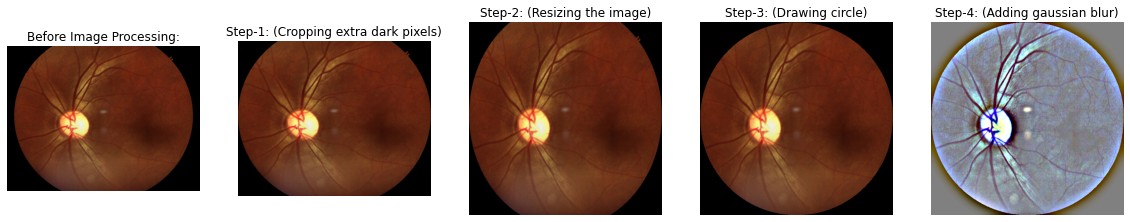

In [23]:
obj1 = ImageProcessing(img_width,img_height, no_channels, sigmaX = 14)
img = r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\train_images\201f882365d3.png'  #random train image
img = cv2.imread(img)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,5))
plotting(img1,'Before Image Processing:',1)
img1 = obj1.cropping_3D(img1)
plotting(img1,'Step-1: (Cropping extra dark pixels)',2)
img1 = cv2.resize(img1, (img_height,img_width))
plotting(img1,'Step-2: (Resizing the image)',3)
img1 = obj1.draw_circle(img1)
plotting(img1,'Step-3: (Drawing circle)',4)
img = obj1.image_preprocessing(img,'True')
plotting(img,'Step-4: (Adding gaussian blur)',5)

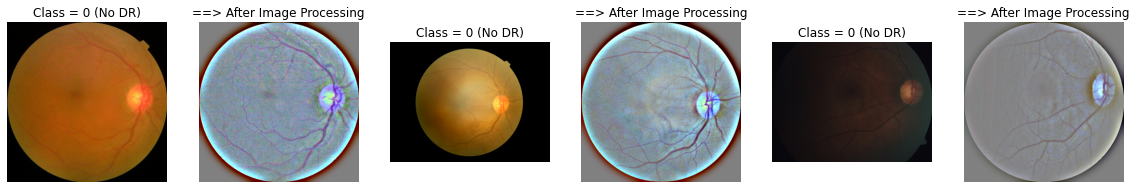

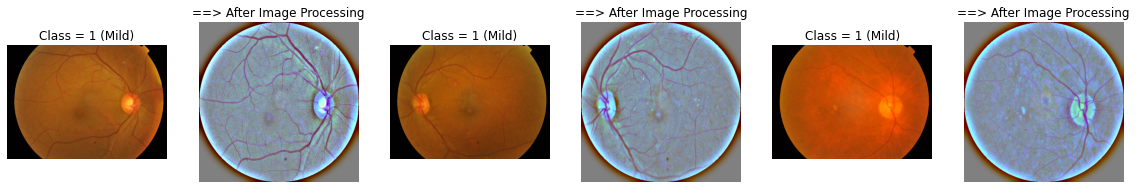

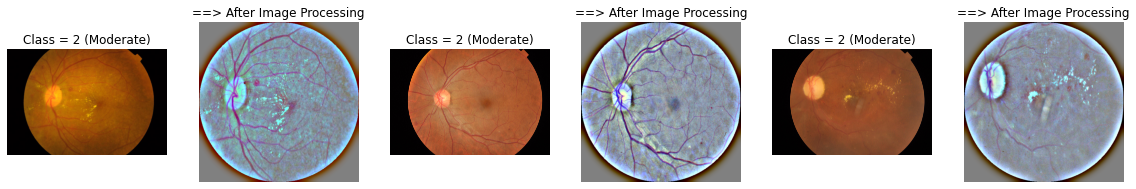

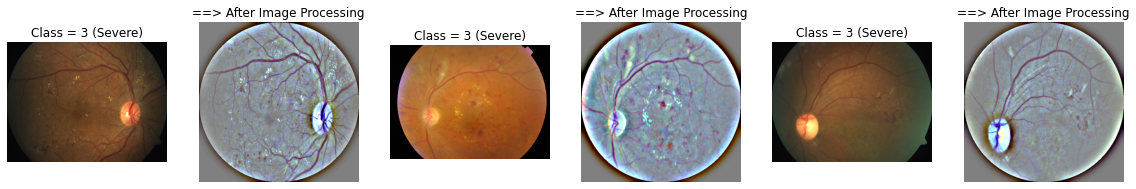

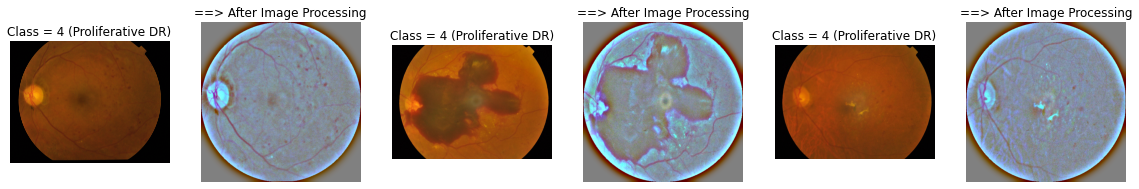

In [24]:
images_per_class(train_labels,3,train_x,True)

## Image Convertion:

In [25]:
def image_2_vector(data, sep):
    """
    This function is used for Converting an images into a vector and storing it in a file (.npy) format.
    Input: data (Series Object) - which contains the path of the images
           sep (String)   - used in file creation
    Output: None - This function doesn't return anything.
    """
    start_time = time.time()  # storing timestamp 
    image_vector = np.empty((len(data),img_width, img_height, no_channels), dtype = np.uint8)
    image_processing = ImageProcessing(img_width, img_height, no_channels, sigmaX)  # Object creation
    if sep !='test':
        c = r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\train_images/'
    else:
        c = r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\test_images/'
    for iter,row in enumerate(tqdm(data)): 
        img_path = c+data.iloc[iter]+'.png'
        img = cv2.imread(img_path)
        img = image_processing.image_preprocessing(img)    #calling image_preprocessing
        image_vector[iter,:,:,:] = img

    if sep == 'training': print("\nShape of the vector:",image_vector.shape)
    else: print("\n\nShape of the vector:",image_vector.shape)
    print("Time taken to process the {} images: {} seconds".format(sep,np.round(time.time()-start_time,5)))
    path = r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images"
    print("... Saving image_vector to {}".format(path+'/'+sep))
    
    if sep == 'training': 
        print("\n","-"*100,"\n")
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(path+'/'+sep+'.npy', image_vector)  #saving file

In [26]:
sigmaX = 14 
image_2_vector(train_x, "training") # function calling 
image_2_vector(validation_x,"validation")  #function calling

100%|██████████████████████████████████████████████████████████████████████████████| 3112/3112 [20:25<00:00,  2.54it/s]



Shape of the vector: (3112, 512, 512, 3)
Time taken to process the training images: 1225.91331 seconds
... Saving image_vector to C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images/training

 ---------------------------------------------------------------------------------------------------- 



100%|████████████████████████████████████████████████████████████████████████████████| 550/550 [03:39<00:00,  2.51it/s]




Shape of the vector: (550, 512, 512, 3)
Time taken to process the validation images: 219.46233 seconds
... Saving image_vector to C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images/validation


In [27]:
test = pd.read_csv(r"C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\data_files\test.csv") 
image_2_vector(test['id_code'], 'test')   #function calling

100%|██████████████████████████████████████████████████████████████████████████████| 1928/1928 [04:09<00:00,  7.72it/s]




Shape of the vector: (1928, 512, 512, 3)
Time taken to process the test images: 249.64446 seconds
... Saving image_vector to C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images/test


In [28]:
train_x = np.load(r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images\training.npy')  #training set
validation_x = np.load(r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images\validation.npy')  #validation set
test_x = np.load(r'C:\Users\PC\Jupyter Notebooks\BIG DATA ANALYTICS PROJECT\processed_images\test.npy')    #test set

### Testing:

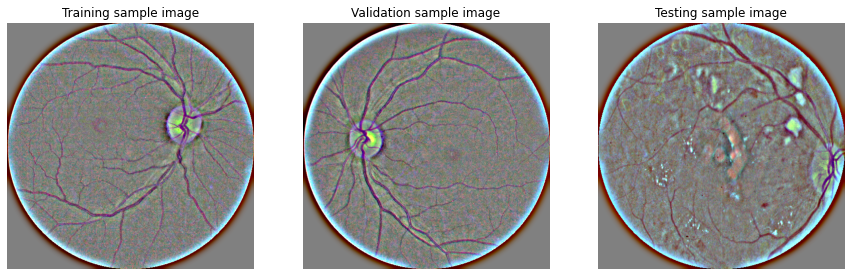

In [29]:
plt.figure(figsize=(15,5)) 
plt.subplot(131)
plt.imshow(train_x[8])   #random training example
plt.axis('off') 
plt.title("Training sample image")
plt.subplot(132)
plt.imshow(validation_x[120])    #random validation example
plt.title("Validation sample image")
plt.axis('off')
plt.subplot(133)
plt.imshow(test_x[1200])        #random test example
plt.title("Testing sample image")
plt.axis('off')
plt.show()
